(writing-custom-steps)=
# Writing custom steps

<!-- Add  overview -->

The Graph executes built-in task classes, or task classes and functions that you implement.
The task parameters include the following:
* `class_name` (str): the relative or absolute class name.
* `handler` (str): the function handler (if class_name is not specified it is the function handler).
* `**class_args`: a set of class `__init__` arguments.

For example, see the following simple `echo` class:

In [2]:
import mlrun

In [3]:
# mlrun: start

In [4]:
# echo class, custom class example
class Echo:
    def __init__(self, context, name=None, **kw):
        self.context = context
        self.name = name
        self.kw = kw
        
    def do(self, x):
        print("Echo:", self.name, x)
        return x

In [5]:
# mlrun: end

Test the graph: first convert the code to function, and then add the step to the graph:

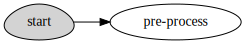

In [7]:
fn_echo = mlrun.code_to_function("echo_function", kind="serving", image="mlrun/mlrun")

graph_echo = fn_echo.set_topology("flow")

graph_echo.to(class_name="Echo", name="pre-process", some_arg='abc')

graph_echo.plot(rankdir='LR')

Create a mock server to test this locally:

In [8]:
echo_server = fn_echo.to_mock_server(current_function="*")

result = echo_server.test("", {"inputs": 123})

print(result)

{'id': '97397ea412334afdb5e4cb7d7c2e6dd3'}
Echo: pre-process {'inputs': 123}


**For more information, see the [Advanced model serving graph notebook example](./graph-example.html)**

<!-- Requires better description - and title? -->

You can use any Python function by specifying the handler name (e.g. `handler=json.dumps`).
The function is triggered with the `event.body` as the first argument, and its result 
is passed to the next step.

Alternatively, you can use classes that can also store some step/configuration and separate the 
one time init logic from the per event logic. The classes are initialized with the `class_args`.
If the class init args contain `context` or `name`, they are initialized with the 
[graph context](./realtime-pipelines.html) and the step name. 

By default, the `class_name` and handler specify a class/function name in the `globals()` (i.e. this module).
Alternatively, those can be full paths to the class (module.submodule.class), e.g. `storey.WriteToParquet`.
You can also pass the module as an argument to functions such as `function.to_mock_server(namespace=module)`.
In this case the class or handler names are also searched in the provided module.
 <!-- the previous sentence needs clarification -->

When using classes the class event handler is invoked on every event with the `event.body`.
If the Task step `full_event` parameter is set to `True` the handler is invoked and returns
the full `event` object. If the class event handler is not specified, it invokes the class `do()` method. 

If you need to implement async behavior, then subclass `storey.MapClass`.